# Proyecto S11 Análisis de Embudo de Eeventos y Test A/A/B

## Introducción 

Trabajo en una empresa emergente que vende productos alimenticios. Debos investigar el comportamiento del usuario para la aplicación de la empresa.

Primero, estudiaremos el embudo de ventas. Para descubrir cómo los usuarios llegan a la etapa de compra. Constestar a las preguntas ¿Cuántos usuarios realmente llegan a esta etapa? ¿Cuántos se atascan en etapas anteriores? ¿Qué etapas en particular?

Luego, observaremos los resultados de un test A/A/B. Al equipo de diseño le gustaría cambiar las fuentes de toda la aplicación, pero la gerencia teme que los usuarios piensen que el nuevo diseño es intimidante. Por ello, deciden tomar una decisión basada en los resultados de un test A/A/B.

La comparación de grupos de control también nos dice cuánto tiempo y datos necesitaremos cuando realicemos más tests.

Utilizarás el mismo dataset para el análisis general y para el análisis A/A/B.

### Descripción de los datos

Descripción de los datos
Cada entrada de registro es una acción de usuario o un evento.

EventName: nombre del evento.

DeviceIDHash: identificador de usuario unívoco.

EventTimestamp: hora del evento.

ExpId: número de experimento. 246 y 247 son los grupos de control, y 248 es el grupo de prueba.

## Librerías 

In [ ]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

# Configuración de gráficos para mejor visualización
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

## Datos

In [3]:
events_data = pd.read_csv("/datasets/logs_exp_us.csv", sep="\t")

## Exploración inicial

In [4]:
# Mostrar información general del dataset para verificar la carga
print(events_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None


In [4]:
# Mostrar las primeras filas del dataset
print(events_data.head(10))

                 EventName         DeviceIDHash  EventTimestamp  ExpId
0         MainScreenAppear  4575588528974610257      1564029816    246
1         MainScreenAppear  7416695313311560658      1564053102    246
2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
3         CartScreenAppear  3518123091307005509      1564054127    248
4  PaymentScreenSuccessful  6217807653094995999      1564055322    248
5         CartScreenAppear  6217807653094995999      1564055323    248
6       OffersScreenAppear  8351860793733343758      1564066242    246
7         MainScreenAppear  5682100281902512875      1564085677    246
8         MainScreenAppear  1850981295691852772      1564086702    247
9         MainScreenAppear  5407636962369102641      1564112112    246


## Correcciones

In [5]:
# Renombrar columnas a formato snake_case y minúsculas
events_data.columns = (events_data.columns
                       .str.lower()  # Convertir a minúsculas
                       .str.replace(' ', '_')  # Reemplazar espacios con "_"
                       .str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True)  # Convertir CamelCase a snake_case
                      )

# Mostrar los nuevos nombres de las columnas
print(events_data.columns)

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')


In [6]:
# Renombrar columnas manualmente
events_data.rename(columns={
    'eventname': 'event_name',
    'deviceidhash': 'device_id_hash',
    'eventtimestamp': 'event_time_stamp',
    'expid': 'exp_group'
}, inplace=True)

# Verificar los nuevos nombres de las columnas
print(events_data.columns)

Index(['event_name', 'device_id_hash', 'event_time_stamp', 'exp_group'], dtype='object')


In [7]:
# Convertir device_id_hash y exp_group a tipo object
events_data['device_id_hash'] = events_data['device_id_hash'].astype(str)
events_data['exp_group'] = events_data['exp_group'].astype(str)

# Convertir event_time_stamp a tipo datetime
events_data['event_time_stamp'] = pd.to_datetime(events_data['event_time_stamp'], unit='s')

# Verificar los cambios en los tipos de datos
print(events_data.dtypes)

event_name                  object
device_id_hash              object
event_time_stamp    datetime64[ns]
exp_group                   object
dtype: object


In [8]:
# Contar valores nulos en cada columna
null_counts = events_data.isnull().sum()

# Mostrar el resultado
print(null_counts)

event_name          0
device_id_hash      0
event_time_stamp    0
exp_group           0
dtype: int64


In [12]:
# 1. Crear la columna date_time a partir de event_time_stamp
events_data['date_time'] = pd.to_datetime(events_data['event_time_stamp'], unit='s')

# 2. Crear la columna date con solo la fecha en formato datetime.date
events_data['date'] = events_data['date_time'].dt.date

# 3. Asegurar que la columna date sea del tipo correcto
events_data['date'] = pd.to_datetime(events_data['date'])  


In [13]:
print(events_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   device_id_hash    244126 non-null  object        
 2   event_time_stamp  244126 non-null  datetime64[ns]
 3   exp_group         244126 non-null  object        
 4   date_time         244126 non-null  datetime64[ns]
 5   date              244126 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 11.2+ MB
None


In [14]:
print(events_data.head(10))

                event_name       device_id_hash    event_time_stamp exp_group  \
0         MainScreenAppear  4575588528974610257 2019-07-25 04:43:36       246   
1         MainScreenAppear  7416695313311560658 2019-07-25 11:11:42       246   
2  PaymentScreenSuccessful  3518123091307005509 2019-07-25 11:28:47       248   
3         CartScreenAppear  3518123091307005509 2019-07-25 11:28:47       248   
4  PaymentScreenSuccessful  6217807653094995999 2019-07-25 11:48:42       248   
5         CartScreenAppear  6217807653094995999 2019-07-25 11:48:43       248   
6       OffersScreenAppear  8351860793733343758 2019-07-25 14:50:42       246   
7         MainScreenAppear  5682100281902512875 2019-07-25 20:14:37       246   
8         MainScreenAppear  1850981295691852772 2019-07-25 20:31:42       247   
9         MainScreenAppear  5407636962369102641 2019-07-26 03:35:12       246   

            date_time       date  
0 2019-07-25 04:43:36 2019-07-25  
1 2019-07-25 11:11:42 2019-07-25  
2 2

### Buscar duplicados en los grupos 

In [15]:
# Contar cuántos grupos diferentes tiene cada usuario
user_group_counts = events_data.groupby('device_id_hash')['exp_group'].nunique()

# Filtrar usuarios que aparecen en más de un grupo
duplicated_users = user_group_counts[user_group_counts > 1]

# Mostrar cuántos usuarios están en más de un grupo
print(f"Número de usuarios en más de un grupo: {len(duplicated_users)}")

# Mostrar algunos ejemplos de usuarios duplicados
print(duplicated_users.head(10))

Número de usuarios en más de un grupo: 0
Series([], Name: exp_group, dtype: int64)


## Estudiar y comprobar los datos

In [17]:
# ¿Cuántos eventos hay en los registros?

# Contar el número total de eventos en el dataset
total_events = events_data.shape[0]

# Contar el número de eventos únicos
unique_events = events_data['event_name'].nunique()

# Crear una tabla con la cuenta de cada evento único
event_counts = events_data['event_name'].value_counts().reset_index()
event_counts.columns = ['event_name', 'count']

# Mostrar resultados
print(f"Número total de eventos registrados: {total_events}")
print(f"Número de eventos únicos: {unique_events}")
print(event_counts)

Número total de eventos registrados: 244126
Número de eventos únicos: 5
                event_name   count
0         MainScreenAppear  119205
1       OffersScreenAppear   46825
2         CartScreenAppear   42731
3  PaymentScreenSuccessful   34313
4                 Tutorial    1052


In [19]:
# ¿Cuántos usuarios hay en los registros?

# Contar el número total de usuarios únicos
total_unique_users = events_data['device_id_hash'].nunique()

# Contar el número de usuarios únicos por grupo experimental
unique_users_by_group = events_data.groupby('exp_group')['device_id_hash'].nunique().reset_index()
unique_users_by_group.columns = ['exp_group', 'unique_users']

# Mostrar resultados
print(f"Número total de usuarios únicos: {total_unique_users}")
print(unique_users_by_group)

Número total de usuarios únicos: 7551
  exp_group  unique_users
0       246          2489
1       247          2520
2       248          2542


In [21]:
# ¿Cuál es el promedio de eventos por usuario?

mean_events_per_user= total_events/total_unique_users

print(f"Promedio de eventos por usuario únicos: {mean_events_per_user}")

Promedio de eventos por usuario únicos: 32.33028737915508


Esto nos dice que cada usuario, en promedio, genera más de 30 eventos en la app, lo que indica una alta interacción. Además, los grupos experimentales están bien balanceados en cantidad de usuarios, lo cual es ideal para el análisis A/A/B. 

In [22]:
# ¿Qué periodo de tiempo cubren los datos?

# Encontrar la fecha mínima y máxima en los datos
min_date = events_data['date_time'].min()
max_date = events_data['date_time'].max()

# Mostrar los resultados
print(f"El dataset cubre desde {min_date} hasta {max_date}")

El dataset cubre desde 2019-07-25 04:43:36 hasta 2019-08-07 21:15:17


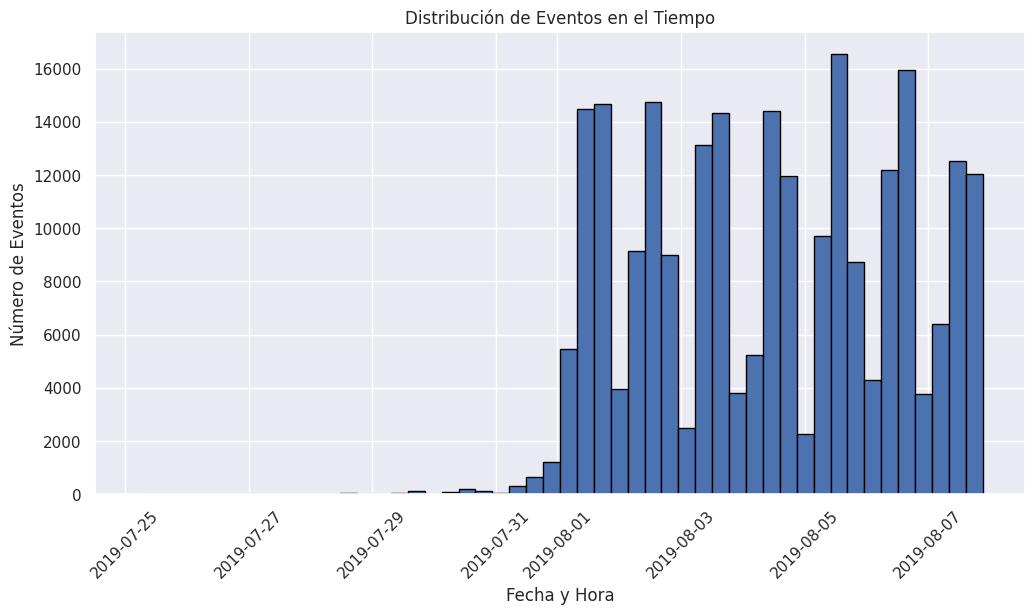

In [23]:
# Crear un histograma de la cantidad de eventos por fecha
plt.figure(figsize=(12,6))
events_data['date_time'].hist(bins=50, edgecolor='black')
plt.xlabel('Fecha y Hora')
plt.ylabel('Número de Eventos')
plt.title('Distribución de Eventos en el Tiempo')
plt.xticks(rotation=45)
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [24]:
# Contar eventos por día
event_counts_by_date = events_data.groupby('date')['event_name'].count().reset_index()
event_counts_by_date.columns = ['date', 'event_count']

# Encontrar la primera fecha con un volumen estable de eventos
threshold = event_counts_by_date['event_count'].median() * 0.5  # Se usa el 50% de la mediana como umbral
valid_start_date = event_counts_by_date[event_counts_by_date['event_count'] > threshold]['date'].min()

# Mostrar la nueva fecha de inicio
print(f"Los datos comienzan a estar completos desde: {valid_start_date}")


Los datos comienzan a estar completos desde: 2019-08-01 00:00:00


In [25]:
# Filtrar los datos para ignorar la sección anterior a la fecha completa
filtered_events_data = events_data[events_data['date'] >= valid_start_date].copy()

# Verificar nueva distribución de fechas
print(f"Nuevo rango de fechas: {filtered_events_data['date'].min()} a {filtered_events_data['date'].max()}")

Nuevo rango de fechas: 2019-08-01 00:00:00 a 2019-08-07 00:00:00


In [28]:
# 1. Contar el número total de eventos después del filtrado
total_events_filtered = filtered_events_data.shape[0]

# 2. Contar el número de eventos únicos y su frecuencia
event_counts_filtered = filtered_events_data['event_name'].value_counts().reset_index()
event_counts_filtered.columns = ['event_name', 'count']

# 3. Contar el número de usuarios únicos por grupo experimental
unique_users_by_group_filtered = filtered_events_data.groupby('exp_group')['device_id_hash'].nunique().reset_index()
unique_users_by_group_filtered.columns = ['exp_group', 'unique_users']

# Mostrar resultados
print(f"Número total de eventos después del filtrado: {total_events_filtered}")
print()
print()
print(event_counts_filtered)
print()
print()
print(unique_users_by_group_filtered)

Número total de eventos después del filtrado: 241298


                event_name   count
0         MainScreenAppear  117431
1       OffersScreenAppear   46350
2         CartScreenAppear   42365
3  PaymentScreenSuccessful   34113
4                 Tutorial    1039


  exp_group  unique_users
0       246          2484
1       247          2513
2       248          2537


Observación Comparativa Antes y Después del Filtrado
Los datos se han limpiado eliminando la parte inicial donde los registros eran incompletos. 

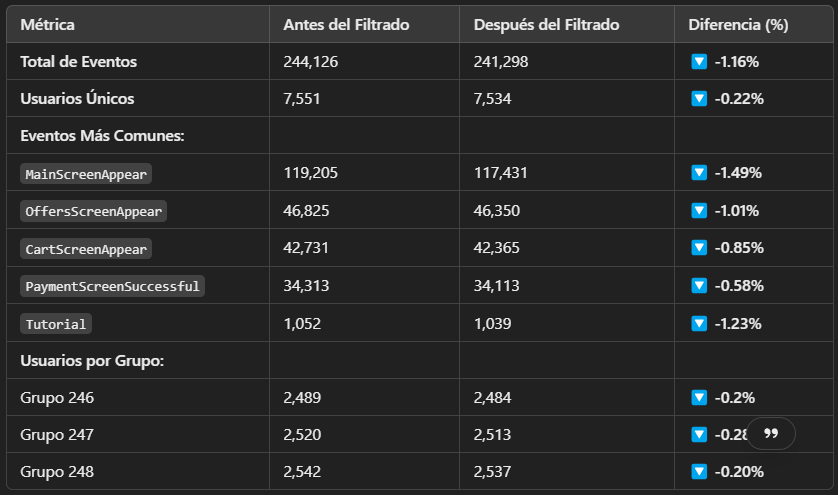

Mínima pérdida de datos: Solo se eliminó ~1.16% de los eventos y ~0.22% de los usuarios, lo que indica que el filtro no afectó significativamente el análisis.

Distribución de eventos estable: No hubo cambios drásticos en la proporción de eventos.

Los grupos experimentales siguen balanceados, lo que es clave para la validez del test A/A/B.

## Estudiar el embudo de eventos

In [30]:
# Eeventos ordenados por frecuencia 

print(event_counts_filtered)

                event_name   count
0         MainScreenAppear  117431
1       OffersScreenAppear   46350
2         CartScreenAppear   42365
3  PaymentScreenSuccessful   34113
4                 Tutorial    1039


In [31]:
# Contar cuántos usuarios únicos realizaron cada tipo de evento
users_per_event = filtered_events_data.groupby('event_name')['device_id_hash'].nunique().reset_index()
users_per_event.columns = ['event_name', 'unique_users']

# Ordenar los eventos de mayor a menor número de usuarios únicos
users_per_event = users_per_event.sort_values(by='unique_users', ascending=False)

print(users_per_event)

                event_name  unique_users
1         MainScreenAppear          7419
2       OffersScreenAppear          4593
0         CartScreenAppear          3734
3  PaymentScreenSuccessful          3539
4                 Tutorial           840


In [32]:
# Calcular la proporción de usuarios que realizaron cada acción al menos una vez
users_per_event['user_proportion'] = users_per_event['unique_users'] / total_unique_users

print(users_per_event)

                event_name  unique_users  user_proportion
1         MainScreenAppear          7419         0.982519
2       OffersScreenAppear          4593         0.608264
0         CartScreenAppear          3734         0.494504
3  PaymentScreenSuccessful          3539         0.468680
4                 Tutorial           840         0.111244


Comentario sobre la Secuencia de Eventos y su Relación con el Embudo de Ventas 
Al observar la distribución de eventos y la proporción de usuarios que los realizaron, se puede inferir el orden en el que ocurren las acciones dentro de la aplicación.

Orden lógico de los eventos en la secuencia principal:

MainScreenAppear (98.25%) → La mayoría de los usuarios inicia en la pantalla principal.

OffersScreenAppear (60.83%) → Más de la mitad de los usuarios avanza a la pantalla de ofertas.

CartScreenAppear (49.45%) → Un porcentaje menor agrega productos al carrito.

PaymentScreenSuccessful (46.87%) → Casi la mitad de los usuarios que visitaron el carrito completan la compra.

Este flujo sugiere un embudo de ventas típico donde los usuarios van avanzando hasta el pago final.

El tutorial: ¿Parte de la secuencia o un evento independiente?
Solo el 11.12% de los usuarios interactuó con Tutorial.
Esto sugiere que el tutorial no forma parte de la secuencia principal del embudo de ventas, sino que es una acción opcional que algunos usuarios eligen.
Si estuviera dentro del flujo, lo lógico sería que ocurriera después de MainScreenAppear, antes de que los usuarios exploren la app.

Conclusión:
El embudo de ventas debe calcularse sin incluir el tutorial, ya que no es parte del flujo natural de compra. Si se incluye, debería estar en una posición temprana dentro de la secuencia.

In [35]:
# Calcular la proporción de usuarios que avanzan de una etapa a la siguiente
funnel_data['conversion_rate'] = funnel_data['unique_users'] / funnel_data['unique_users'].shift(1)

# Reemplazar el primer valor NaN (que no tiene referencia previa) con 1
funnel_data['conversion_rate'].fillna(1, inplace=True)

print(funnel_data)

                event_name  unique_users  user_proportion  conversion_rate
1         MainScreenAppear          7419         0.982519         1.000000
2       OffersScreenAppear          4593         0.608264         0.619086
0         CartScreenAppear          3734         0.494504         0.812976
3  PaymentScreenSuccessful          3539         0.468680         0.947777


Análisis de la pérdida de usuarios en cada etapa
A partir de los valores en conversion_rate:

De MainScreenAppear a OffersScreenAppear: 61.91% de retención

Pérdida de ~38.1% de usuarios en esta transición.
Esto sugiere que muchos usuarios no interactúan con la pantalla de ofertas después de entrar a la app.

De OffersScreenAppear a CartScreenAppear: 81.30% de retención

Menor caída aquí, pero aún hay una pérdida de ~18.7% de los usuarios.
Esto indica que algunos usuarios exploran ofertas, pero no agregan productos al carrito.
De CartScreenAppear a PaymentScreenSuccessful: 94.78% de retención

La menor pérdida de usuarios (~5.2%).
Esto significa que la mayoría de los usuarios que llegan al carrito terminan completando la compra, lo que indica que el proceso de pago es eficiente.

Conclusión

La mayor fuga de usuarios ocurre en la primera etapa (38.1% de caída).

Posible problema: La pantalla principal puede no estar guiando lo suficiente a los usuarios hacia la sección de ofertas.

Recomendación: Analizar qué tan visible y accesible es la transición desde MainScreenAppear a OffersScreenAppear.

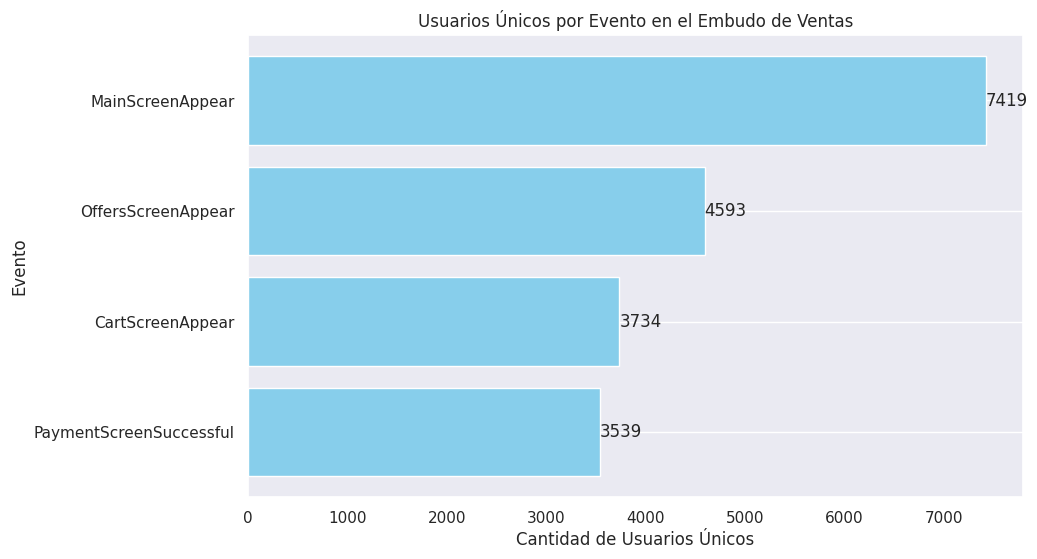

In [36]:


# Crear el gráfico de barras horizontales para usuarios únicos por evento
plt.figure(figsize=(10, 6))
plt.barh(funnel_data['event_name'], funnel_data['unique_users'], color='skyblue')

# Agregar etiquetas de datos
for index, value in enumerate(funnel_data['unique_users']):
    plt.text(value, index, str(value), va='center')

# Configuración del gráfico
plt.xlabel("Cantidad de Usuarios Únicos")
plt.ylabel("Evento")
plt.title("Usuarios Únicos por Evento en el Embudo de Ventas")
plt.gca().invert_yaxis()  # Invertir el eje para mejor lectura
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


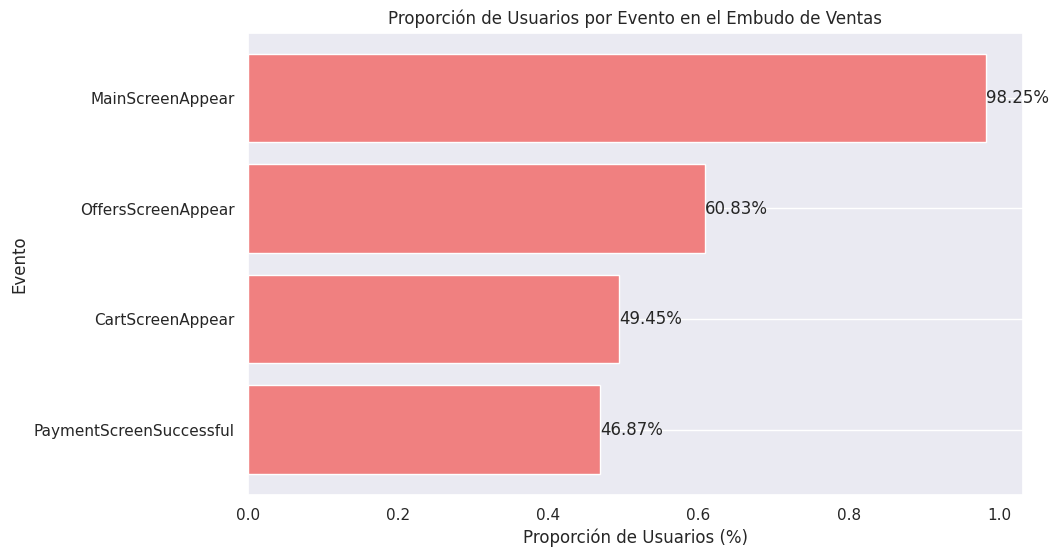

In [38]:
# Crear el gráfico de barras horizontales para la proporción de usuarios por evento
plt.figure(figsize=(10, 6))
plt.barh(funnel_data['event_name'], funnel_data['user_proportion'], color='lightcoral')

# Agregar etiquetas de datos en porcentaje
for index, value in enumerate(funnel_data['user_proportion']):
    plt.text(value, index, f"{value:.2%}", va='center')

# Configuración del gráfico
plt.xlabel("Proporción de Usuarios (%)")
plt.ylabel("Evento")
plt.title("Proporción de Usuarios por Evento en el Embudo de Ventas")
plt.gca().invert_yaxis()  # Invertir el eje para mejor lectura
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [39]:
#¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

# Definir el orden correcto del embudo
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Filtrar solo los usuarios que realizaron eventos del embudo
funnel_users = filtered_events_data[filtered_events_data['event_name'].isin(funnel_events)]

# Ordenar los eventos por usuario y fecha para garantizar la secuencia
funnel_users = funnel_users.sort_values(by=['device_id_hash', 'date_time'])

# Crear un diccionario para registrar en qué etapa se encuentra cada usuario
user_stages = {}

# Identificar usuarios que pasan por todas las etapas en orden
for user, events in funnel_users.groupby('device_id_hash'):
    user_sequence = list(events['event_name'])  # Extraer la secuencia de eventos del usuario
    if all(event in user_sequence for event in funnel_events):  # Verificar si el usuario completó el embudo
        user_stages[user] = True
    else:
        user_stages[user] = False

# Calcular el porcentaje de usuarios que completaron el embudo
users_start = filtered_events_data['device_id_hash'].nunique()  # Total de usuarios únicos
users_complete = sum(user_stages.values())  # Usuarios que completaron todo el embudo

completion_rate = (users_complete / users_start) * 100

# Mostrar el resultado
print(f"Porcentaje de usuarios que completan el embudo: {completion_rate:.2f}%")


Porcentaje de usuarios que completan el embudo: 45.51%


In [40]:
# Calcular el número de usuarios que completan el embudo
users_complete_count = int(users_start * (completion_rate / 100))

# Mostrar el resultado
print(f"Número de usuarios que completan el embudo: {users_complete_count}")

Número de usuarios que completan el embudo: 3429


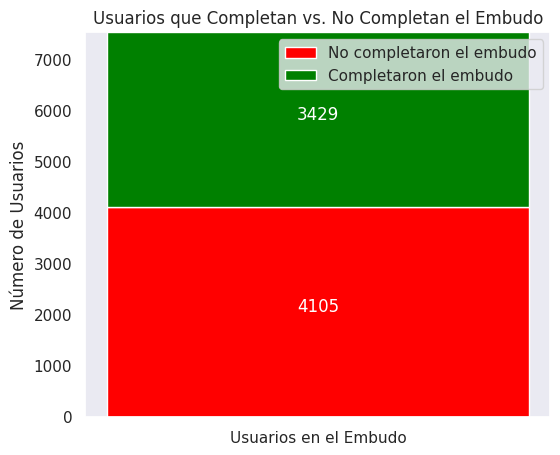

In [42]:


# Calcular el número de usuarios que no completan el embudo
users_not_complete = users_start - users_complete_count

# Datos para la barra apilada
categories = ["Usuarios en el Embudo"]
values_complete = [users_complete_count]
values_not_complete = [users_not_complete]

# Crear el gráfico de barras apiladas
plt.figure(figsize=(6, 5))
plt.bar(categories, values_not_complete, color='red', label="No completaron el embudo")
plt.bar(categories, values_complete, bottom=values_not_complete, color='green', label="Completaron el embudo")

# Agregar etiquetas de datos dentro de las barras
plt.text(0, users_not_complete / 2, str(users_not_complete), ha='center', fontsize=12, color='white')
plt.text(0, users_not_complete + (users_complete_count / 2), str(users_complete_count), ha='center', fontsize=12, color='white')

# Configuración del gráfico
plt.ylabel("Número de Usuarios")
plt.title("Usuarios que Completan vs. No Completan el Embudo")
plt.legend()
plt.ylim(0, users_start)  # Asegurar que el eje Y cubra el total de usuarios
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()



## Estudiar los resultados del experimento

In [43]:
unique_users_by_group = filtered_events_data.groupby('exp_group')['device_id_hash'].nunique().reset_index()
unique_users_by_group.columns = ['exp_group', 'unique_users']

print(unique_users_by_group)

  exp_group  unique_users
0       246          2484
1       247          2513
2       248          2537


### Comparación de eventos A/A

In [ ]:

# Definir la métrica a comparar → Proporción de usuarios que completan el embudo.
# Realizar un test de hipótesis → Usaremos una prueba de proporciones (proportions_ztest) para comparar las tasas de conversión.


# Definir el orden correcto del embudo
funnel_events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Filtrar solo los eventos del embudo
funnel_users = filtered_events_data[filtered_events_data['event_name'].isin(funnel_events)].copy()

# Ordenar eventos por usuario y fecha
funnel_users = funnel_users.sort_values(by=['device_id_hash', 'date_time'])

# Filtrar usuarios que completaron el embudo en cada grupo
def users_completed_funnel(df, group):
    """ Devuelve el número de usuarios en un grupo que completaron todo el embudo en orden """
    users_in_group = df[df['exp_group'] == group].groupby('device_id_hash')['event_name'].apply(list)
    return sum(1 for events in users_in_group if all(event in events for event in funnel_events))

# Calcular usuarios que completaron el embudo en cada grupo
users_complete_246 = users_completed_funnel(funnel_users, '246')
users_complete_247 = users_completed_funnel(funnel_users, '247')

# Contar usuarios totales en cada grupo
total_users_246 = filtered_events_data[filtered_events_data['exp_group'] == '246']['device_id_hash'].nunique()
total_users_247 = filtered_events_data[filtered_events_data['exp_group'] == '247']['device_id_hash'].nunique()

# Crear las proporciones de conversión
conv_rate_246 = users_complete_246 / total_users_246
conv_rate_247 = users_complete_247 / total_users_247

# Prueba de hipótesis: Test Z para comparar proporciones
counts = np.array([users_complete_246, users_complete_247])
nobs = np.array([total_users_246, total_users_247])
z_stat, p_value = proportions_ztest(counts, nobs)

# Mostrar resultados
print(f"Proporción de conversión en grupo 246: {conv_rate_246:.4f}")
print(f"Proporción de conversión en grupo 247: {conv_rate_247:.4f}")
print(f"Estadístico Z: {z_stat:.4f}")
print(f"Valor p: {p_value:.4f}")

# Interpretación del resultado
alpha = 0.05  # Nivel de significancia
if p_value < alpha:
    print("Hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")
else:
    print("No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.")


Proporción de conversión en grupo 246: 0.4694
Proporción de conversión en grupo 247: 0.4477
Estadístico Z: 1.5415
Valor p: 0.1232
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247.


In [46]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

#Estrategia:
#Encontrar el evento más popular (más frecuente en el dataset).
#Comparar la cantidad de usuarios que realizaron cada evento en los grupos 246 y 247.
#Calcular la proporción de usuarios que realizaron cada evento en cada grupo.
#Realizar un test de hipótesis (proportions_ztest) para cada evento.
#Automatizar todo con una función para ahorrar tiempo.


# Paso 1: Encontrar el evento más popular
most_popular_event = filtered_events_data['event_name'].value_counts().idxmax()
print(f" El evento más popular es: {most_popular_event}")

# Paso 2: Definir función para comparar eventos entre los grupos de control
def test_event_significance(event_name):
    """Realiza un test estadístico para verificar si la proporción de usuarios que realizaron un evento es diferente en los grupos de control (246 vs 247)"""
    
    # Contar cuántos usuarios realizaron el evento en cada grupo
    users_246 = filtered_events_data[(filtered_events_data['exp_group'] == '246') & 
                                     (filtered_events_data['event_name'] == event_name)]['device_id_hash'].nunique()
    users_247 = filtered_events_data[(filtered_events_data['exp_group'] == '247') & 
                                     (filtered_events_data['event_name'] == event_name)]['device_id_hash'].nunique()
    
    # Total de usuarios en cada grupo
    total_users_246 = filtered_events_data[filtered_events_data['exp_group'] == '246']['device_id_hash'].nunique()
    total_users_247 = filtered_events_data[filtered_events_data['exp_group'] == '247']['device_id_hash'].nunique()
    
    # Calcular proporciones
    prop_246 = users_246 / total_users_246
    prop_247 = users_247 / total_users_247
    
    # Test estadístico (proportions_ztest)
    counts = np.array([users_246, users_247])
    nobs = np.array([total_users_246, total_users_247])
    z_stat, p_value = proportions_ztest(counts, nobs)

    # Mostrar resultados
    print(f"\n Evento: {event_name}")
    print(f"Usuarios que realizaron el evento en grupo 246: {users_246} ({prop_246:.4%})")
    print(f"Usuarios que realizaron el evento en grupo 247: {users_247} ({prop_247:.4%})")
    print(f"Estadístico Z: {z_stat:.4f}")
    print(f"Valor p: {p_value:.4f}")

    # Interpretación
    alpha = 0.05
    if p_value < alpha:
        print("Hay una diferencia estadísticamente significativa entre los grupos 246 y 247 para este evento.")
    else:
        print("No hay una diferencia estadísticamente significativa entre los grupos 246 y 247 para este evento.")

# Paso 3: Aplicar la función al evento más popular
test_event_significance(most_popular_event)

# Paso 4: Aplicar la función a todos los eventos (para verificar que los grupos se dividieron correctamente)
print("\nComparación de todos los eventos:")
for event in filtered_events_data['event_name'].unique():
    test_event_significance(event)


 El evento más popular es: MainScreenAppear

 Evento: MainScreenAppear
Usuarios que realizaron el evento en grupo 246: 2450 (98.6312%)
Usuarios que realizaron el evento en grupo 247: 2476 (98.5277%)
Estadístico Z: 0.3093
Valor p: 0.7571
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247 para este evento.

Comparación de todos los eventos:

 Evento: Tutorial
Usuarios que realizaron el evento en grupo 246: 278 (11.1916%)
Usuarios que realizaron el evento en grupo 247: 283 (11.2614%)
Estadístico Z: -0.0782
Valor p: 0.9377
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247 para este evento.

 Evento: MainScreenAppear
Usuarios que realizaron el evento en grupo 246: 2450 (98.6312%)
Usuarios que realizaron el evento en grupo 247: 2476 (98.5277%)
Estadístico Z: 0.3093
Valor p: 0.7571
No hay una diferencia estadísticamente significativa entre los grupos 246 y 247 para este evento.

 Evento: OffersScreenAppear
Usuarios que realizaron el e

### Comparación de eventos A/A/B

In [50]:
#Estrategia:
#Para cada evento, comparar la cantidad de usuarios únicos en los grupos 248 vs. 246 y 248 vs. 247.
#Calcular la proporción de usuarios que realizaron el evento en cada grupo.
#Realizar un test de hipótesis (proportions_ztest) para determinar si hay diferencias significativas.

import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

def compare_experiment_vs_control(event_name, control_group, experiment_group='248'):
    """Compara un evento entre el grupo experimental y un grupo de control."""
    
    # Contar cuántos usuarios realizaron el evento en cada grupo
    users_control = filtered_events_data[(filtered_events_data['exp_group'] == control_group) & 
                                         (filtered_events_data['event_name'] == event_name)]['device_id_hash'].nunique()
    
    users_experiment = filtered_events_data[(filtered_events_data['exp_group'] == experiment_group) & 
                                            (filtered_events_data['event_name'] == event_name)]['device_id_hash'].nunique()
    
    # Contar total de usuarios en cada grupo
    total_users_control = filtered_events_data[filtered_events_data['exp_group'] == control_group]['device_id_hash'].nunique()
    total_users_experiment = filtered_events_data[filtered_events_data['exp_group'] == experiment_group]['device_id_hash'].nunique()
    
    # **Evitar división por cero**
    if total_users_control == 0 or total_users_experiment == 0:
        print(f"\nEvento: {event_name} | Uno de los grupos no tiene usuarios, se omite la prueba.")
        return
    
    # Calcular proporciones
    prop_control = users_control / total_users_control
    prop_experiment = users_experiment / total_users_experiment
    
    # Test de proporciones (proportions_ztest)
    counts = np.array([users_control, users_experiment])
    nobs = np.array([total_users_control, total_users_experiment])
    z_stat, p_value = proportions_ztest(counts, nobs)

    # Mostrar resultados
    print(f"\nEvento: {event_name} | Comparando {control_group} vs {experiment_group}")
    print(f"Usuarios en {control_group}: {users_control} ({prop_control:.4%})")
    print(f"Usuarios en {experiment_group}: {users_experiment} ({prop_experiment:.4%})")
    print(f"Estadístico Z: {z_stat:.4f}")
    print(f"Valor p: {p_value:.4f}")

    # Interpretación
    alpha = 0.05
    if p_value < alpha:
        print("Hay una diferencia estadísticamente significativa entre estos grupos para este evento.")
    else:
        print("No hay una diferencia estadísticamente significativa entre estos grupos para este evento.")

# Comparar grupo experimental (248) con cada grupo de control individualmente
print("\nComparación entre grupo experimental y grupos de control individualmente:")
for event in filtered_events_data['event_name'].unique():
    compare_experiment_vs_control(event, '246')  # Comparar con grupo de control 246
    compare_experiment_vs_control(event, '247')  # Comparar con grupo de control 247




Comparación entre grupo experimental y grupos de control individualmente:

Evento: Tutorial | Comparando 246 vs 248
Usuarios en 246: 278 (11.1916%)
Usuarios en 248: 279 (10.9972%)
Estadístico Z: 0.2193
Valor p: 0.8264
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: Tutorial | Comparando 247 vs 248
Usuarios en 247: 283 (11.2614%)
Usuarios en 248: 279 (10.9972%)
Estadístico Z: 0.2985
Valor p: 0.7653
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: MainScreenAppear | Comparando 246 vs 248
Usuarios en 246: 2450 (98.6312%)
Usuarios en 248: 2493 (98.2657%)
Estadístico Z: 1.0473
Valor p: 0.2950
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: MainScreenAppear | Comparando 247 vs 248
Usuarios en 247: 2476 (98.5277%)
Usuarios en 248: 2493 (98.2657%)
Estadístico Z: 0.7410
Valor p: 0.4587
No hay una diferencia estadísticamente significativa entre 

Análisis de los Resultados de la Comparación Grupo Experimental (248) vs Grupos de Control (246 y 247)

Observaciones Clave:

No se encontraron diferencias estadísticamente significativas en ninguno de los eventos.

En todas las pruebas, el valor p fue mayor a 0.05, indicando que las diferencias entre los grupos pueden deberse al azar.
El evento más afectado fue CartScreenAppear (p = 0.0784 en 246 vs 248).

Aunque no es estadísticamente significativo, el grupo experimental muestra una ligera tendencia a menos usuarios llegando a la pantalla del carrito.
Posible hipótesis: El cambio en las fuentes pudo haber generado una mínima fricción en la navegación.
La pantalla de pago (PaymentScreenSuccessful) también tiene una leve caída en 248, pero sin significancia estadística.

No parece haber una gran diferencia en la conversión final.
El tutorial y la pantalla principal (MainScreenAppear) tienen valores p altos (>0.75), lo que sugiere que la primera interacción con la app no se vio afectada por el cambio en las fuentes.

Interpretación:

Los grupos de control (246 y 247) y el grupo experimental (248) parecen haber sido divididos correctamente.

El cambio en las fuentes no generó un impacto significativo en la navegación y conversión de los usuarios.

Se observa una pequeña tendencia a la baja en la pantalla de carrito, pero no es suficiente para concluir que hubo un impacto real.

In [51]:
#Estrategia:
#Fusionar los grupos de control (246 + 247) y compararlos con el grupo experimental (248).
#Para cada evento, calcular la cantidad de usuarios y la proporción en cada grupo.
#Realizar un test estadístico (proportions_ztest) para ver si hay diferencias significativas.

import numpy as np
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

def compare_experiment_vs_combined_control(event_name):
    """Compara un evento entre el grupo experimental (248) y la combinación de los grupos de control (246 + 247)."""
    
    # Contar usuarios únicos que realizaron el evento en los grupos de control combinados (246 + 247)
    users_control = filtered_events_data[(filtered_events_data['exp_group'].isin(['246', '247'])) & 
                                         (filtered_events_data['event_name'] == event_name)]['device_id_hash'].nunique()
    
    # Contar usuarios únicos en el grupo experimental (248)
    users_experiment = filtered_events_data[(filtered_events_data['exp_group'] == '248') & 
                                            (filtered_events_data['event_name'] == event_name)]['device_id_hash'].nunique()
    
    # Contar total de usuarios en los grupos combinados y en el experimental
    total_users_control = filtered_events_data[filtered_events_data['exp_group'].isin(['246', '247'])]['device_id_hash'].nunique()
    total_users_experiment = filtered_events_data[filtered_events_data['exp_group'] == '248']['device_id_hash'].nunique()
    
    # **Evitar división por cero**
    if total_users_control == 0 or total_users_experiment == 0:
        print(f"\nEvento: {event_name} | Uno de los grupos no tiene usuarios, se omite la prueba.")
        return
    
    # Calcular proporciones
    prop_control = users_control / total_users_control
    prop_experiment = users_experiment / total_users_experiment
    
    # Test estadístico (proportions_ztest)
    counts = np.array([users_control, users_experiment])
    nobs = np.array([total_users_control, total_users_experiment])
    z_stat, p_value = proportions_ztest(counts, nobs)

    # Mostrar resultados
    print(f"\nEvento: {event_name} | Comparando Control (246+247) vs 248")
    print(f"Usuarios en Control: {users_control} ({prop_control:.4%})")
    print(f"Usuarios en Experimental: {users_experiment} ({prop_experiment:.4%})")
    print(f"Estadístico Z: {z_stat:.4f}")
    print(f"Valor p: {p_value:.4f}")

    # Interpretación
    alpha = 0.05
    if p_value < alpha:
        print("Hay una diferencia estadísticamente significativa entre estos grupos para este evento.")
    else:
        print("No hay una diferencia estadísticamente significativa entre estos grupos para este evento.")

# Comparar grupo experimental (248) con el grupo de control combinado (246 + 247) para todos los eventos
print("\nComparación entre grupo experimental y grupos de control combinados:")
for event in filtered_events_data['event_name'].unique():
    compare_experiment_vs_combined_control(event)



Comparación entre grupo experimental y grupos de control combinados:

Evento: Tutorial | Comparando Control (246+247) vs 248
Usuarios en Control: 561 (11.2267%)
Usuarios en Experimental: 279 (10.9972%)
Estadístico Z: 0.2991
Valor p: 0.7649
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: MainScreenAppear | Comparando Control (246+247) vs 248
Usuarios en Control: 4926 (98.5791%)
Usuarios en Experimental: 2493 (98.2657%)
Estadístico Z: 1.0489
Valor p: 0.2942
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: OffersScreenAppear | Comparando Control (246+247) vs 248
Usuarios en Control: 3062 (61.2768%)
Usuarios en Experimental: 1531 (60.3469%)
Estadístico Z: 0.7819
Valor p: 0.4343
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: CartScreenAppear | Comparando Control (246+247) vs 248
Usuarios en Control: 2504 (50.1101%)
Usuarios en Experimental

Análisis de los Resultados: Grupo Experimental (248) vs Control Combinado (246 + 247)
Observaciones Clave:

No se encontraron diferencias estadísticamente significativas en ningún evento.

En todas las pruebas, el valor p fue mayor a 0.05, lo que indica que las diferencias observadas pueden deberse al azar.
Resultados muy similares a las pruebas individuales contra 246 y 247.

El grupo experimental (fuentes alteradas) no mostró cambios en la tasa de interacción con los eventos.
Incluso con una muestra más grande (control combinado), no hubo evidencia de impacto en la navegación o conversión.
La mayor diferencia sigue siendo en CartScreenAppear (p = 0.1818).

Aunque sigue sin ser significativa, el grupo experimental muestra una leve tendencia a tener menos usuarios en la pantalla del carrito.
Posible hipótesis: El cambio en las fuentes pudo haber causado una mínima fricción visual o en la experiencia del usuario.
El embudo de conversión se mantiene estable entre grupos.

PaymentScreenSuccessful (compra finalizada) sigue sin mostrar diferencias significativas (p = 0.6004).
Esto sugiere que el proceso de compra no se vio afectado por el diseño.

Conclusiones Finales del Experimento
No hay evidencia de que el cambio en las fuentes haya afectado la interacción de los usuarios en la app.

Los grupos de control y el grupo experimental están bien balanceados y correctamente divididos.

No se encontraron diferencias en la conversión o navegación, lo que indica que la actualización del diseño no tuvo un impacto negativo ni positivo significativo.

Si se decide implementar el cambio de fuentes, no debería afectar la tasa de conversión o el comportamiento del usuario.



## Ajuste de nivel de significancia 

In [52]:
# Nivel de significancia utilizado en todas las pruebas
alpha = 0.05
print(f"El nivel de significancia utilizado en las pruebas de hipótesis ha sido: {alpha} (5%)")

El nivel de significancia utilizado en las pruebas de hipótesis ha sido: 0.05 (5%)


In [53]:
# Número de eventos analizados
num_events = len(filtered_events_data['event_name'].unique())

# Número de pruebas realizadas en cada comparación
num_tests_aa = num_events  # Comparación 246 vs 247
num_tests_ab_individual = num_events * 2  # Comparación 248 vs 246 y 248 vs 247
num_tests_ab_combined = num_events  # Comparación 248 vs (246+247)

# Sumar todas las pruebas realizadas
total_tests = num_tests_aa + num_tests_ab_individual + num_tests_ab_combined

# Mostrar resultados
print(f"Número total de pruebas de hipótesis realizadas: {total_tests}")
print(f" - Pruebas A/A (246 vs 247): {num_tests_aa}")
print(f" - Pruebas A/B individuales (248 vs 246 y 248 vs 247): {num_tests_ab_individual}")
print(f" - Pruebas A/B combinadas (248 vs (246+247)): {num_tests_ab_combined}")

Número total de pruebas de hipótesis realizadas: 20
 - Pruebas A/A (246 vs 247): 5
 - Pruebas A/B individuales (248 vs 246 y 248 vs 247): 10
 - Pruebas A/B combinadas (248 vs (246+247)): 5


In [54]:
# Aplicar corrección de Bonferroni
adjusted_alpha = alpha / total_tests

# Mostrar resultado
print(f"Nivel de significancia ajustado con corrección de Bonferroni: {adjusted_alpha:.6f}")

Nivel de significancia ajustado con corrección de Bonferroni: 0.002500


In [55]:
# Nuevo nivel de significancia ajustado
new_alpha = adjusted_alpha

print("\n**Revisión de la Prueba A/A (246 vs 247) con α ajustado**:")
for event in filtered_events_data['event_name'].unique():
    compare_experiment_vs_control(event, '246', '247')  # Prueba A/A


**Revisión de la Prueba A/A (246 vs 247) con α ajustado**:

Evento: Tutorial | Comparando 246 vs 247
Usuarios en 246: 278 (11.1916%)
Usuarios en 247: 283 (11.2614%)
Estadístico Z: -0.0782
Valor p: 0.9377
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: MainScreenAppear | Comparando 246 vs 247
Usuarios en 246: 2450 (98.6312%)
Usuarios en 247: 2476 (98.5277%)
Estadístico Z: 0.3093
Valor p: 0.7571
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: OffersScreenAppear | Comparando 246 vs 247
Usuarios en 246: 1542 (62.0773%)
Usuarios en 247: 1520 (60.4855%)
Estadístico Z: 1.1550
Valor p: 0.2481
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: CartScreenAppear | Comparando 246 vs 247
Usuarios en 246: 1266 (50.9662%)
Usuarios en 247: 1238 (49.2638%)
Estadístico Z: 1.2034
Valor p: 0.2288
No hay una diferencia estadísticamente significativa entre es

In [57]:
print("\n**Revisión de la Prueba A/B (248 vs 246 y 248 vs 247) con α ajustado**:")
for event in filtered_events_data['event_name'].unique():
    compare_experiment_vs_control(event, '246', '248')  # Grupo experimental vs 246
    compare_experiment_vs_control(event, '247', '248')  # Grupo experimental vs 247



**Revisión de la Prueba A/B (248 vs 246 y 248 vs 247) con α ajustado**:

Evento: Tutorial | Comparando 246 vs 248
Usuarios en 246: 278 (11.1916%)
Usuarios en 248: 279 (10.9972%)
Estadístico Z: 0.2193
Valor p: 0.8264
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: Tutorial | Comparando 247 vs 248
Usuarios en 247: 283 (11.2614%)
Usuarios en 248: 279 (10.9972%)
Estadístico Z: 0.2985
Valor p: 0.7653
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: MainScreenAppear | Comparando 246 vs 248
Usuarios en 246: 2450 (98.6312%)
Usuarios en 248: 2493 (98.2657%)
Estadístico Z: 1.0473
Valor p: 0.2950
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: MainScreenAppear | Comparando 247 vs 248
Usuarios en 247: 2476 (98.5277%)
Usuarios en 248: 2493 (98.2657%)
Estadístico Z: 0.7410
Valor p: 0.4587
No hay una diferencia estadísticamente significativa entre es

In [58]:
print("\n**Revisión de la Prueba A/B (248 vs 246+247) con α ajustado**:")
for event in filtered_events_data['event_name'].unique():
    compare_experiment_vs_combined_control(event)


**Revisión de la Prueba A/B (248 vs 246+247) con α ajustado**:

Evento: Tutorial | Comparando Control (246+247) vs 248
Usuarios en Control: 561 (11.2267%)
Usuarios en Experimental: 279 (10.9972%)
Estadístico Z: 0.2991
Valor p: 0.7649
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: MainScreenAppear | Comparando Control (246+247) vs 248
Usuarios en Control: 4926 (98.5791%)
Usuarios en Experimental: 2493 (98.2657%)
Estadístico Z: 1.0489
Valor p: 0.2942
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: OffersScreenAppear | Comparando Control (246+247) vs 248
Usuarios en Control: 3062 (61.2768%)
Usuarios en Experimental: 1531 (60.3469%)
Estadístico Z: 0.7819
Valor p: 0.4343
No hay una diferencia estadísticamente significativa entre estos grupos para este evento.

Evento: CartScreenAppear | Comparando Control (246+247) vs 248
Usuarios en Control: 2504 (50.1101%)
Usuarios en Experimental: 1230

Análisis Final: ¿Cambia algo con el Nivel de Significancia Ajustado?
Después de ejecutar las pruebas nuevamente con el nivel de significancia más estricto (α = 0.0025), los resultados se mantuvieron sin diferencias significativas en todos los eventos.

Observaciones Clave:
No hubo cambios en las conclusiones anteriores.

Ninguna prueba resultó estadísticamente significativa con el nivel de significancia ajustado.
Esto indica que el cambio de fuentes en el grupo experimental (248) no generó un impacto real en la interacción de los usuarios.
El evento CartScreenAppear sigue teniendo la mayor diferencia relativa, pero sin significancia estadística.

En todas las pruebas, este evento mostró una leve tendencia a menos usuarios en el grupo experimental.
Sin embargo, el valor p sigue por encima del umbral (p = 0.1818 con el control combinado), lo que indica que la diferencia observada es probable que sea por azar.
El resto de los eventos tienen valores p muy altos (> 0.2), lo que refuerza la conclusión de que no hubo impacto significativo.

Especialmente en la etapa de PaymentScreenSuccessful (p = 0.6004 con control combinado), lo que indica que el proceso de compra no se vio afectado.

Conclusiones Finales del Experimento:

El cambio de fuentes en la interfaz no afectó significativamente el comportamiento de los usuarios en la aplicación.

Las pruebas A/A confirmaron que los grupos de control (246 y 247) fueron divididos correctamente.

No se encontraron diferencias en la conversión, lo que sugiere que la experiencia del usuario no se vio impactada negativamente ni positivamente.

Si la empresa decide implementar el cambio de fuentes, puede hacerlo sin temor a afectar las métricas clave del embudo.
